In [1]:
!pip install -q malariagen_data

In [2]:
import malariagen_data
import dask.array as da
import numpy as np
import functools

In [3]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

In [4]:
@functools.lru_cache(maxsize=None)
def compute_cov_var(sample_sets):
    ncs = []
    for contig in "2R", "2L", "3R", "3L":
        ds = ag3.cnv_hmm(contig=contig, sample_sets=sample_sets)
        nc = ds['call_NormCov'].data
        ncs.append(nc)
    nc = da.concatenate(ncs, axis=0).compute()
    out = np.zeros(nc.shape[1], dtype=float)
    for j in range(nc.shape[1]):
        x = nc[:, j]
        xn = x[~np.isnan(x)]
        pc99 = np.percentile(xn, 99)
        xnn = xn[xn < pc99]
        v = np.var(xnn)
        out[j] = v
    return out
    

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [6]:
def compare_variances(sample_sets):

    me = compute_cov_var(sample_sets=sample_sets) 
    
    # we've stored Eric's precomputed variance values in the discordant reads
    # datasets, access them from there
    ds_dr = ag3.cnv_discordant_read_calls(contig="2R", sample_sets=sample_sets)
    eric = ds_dr['sample_coverage_variance'].values
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(me, eric, 'bo')
    ax.set_xlabel('me')
    ax.set_ylabel('Eric')
    ax.set_title(sample_sets)
    ax.axhline(0.2);

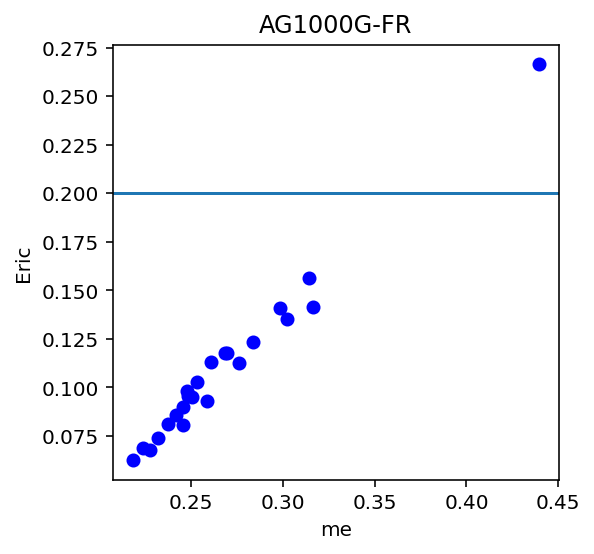

In [7]:
compare_variances("AG1000G-FR")

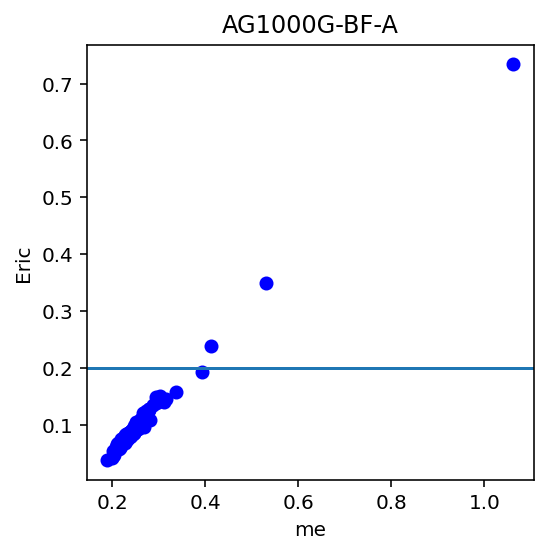

In [8]:
compare_variances("AG1000G-BF-A")

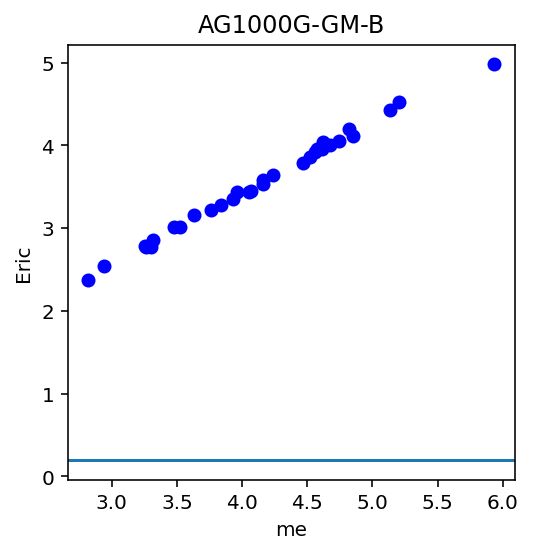

In [9]:
compare_variances("AG1000G-GM-B")